### Описание набора данных
Набор данных о зарплатах в Data Science содержит 11 колонок, каждая из которых:

- **work_year**: Год, в котором была выплачена зарплата.
- **experience_level**: Уровень опыта на работе в течение данного года.
- **employment_type**: Тип занятости для данной роли.
- **job_title**: Название должности, на которой работали в течение года.
- **salary**: Общая сумма выплаченной брутто-зарплаты.
- **salary_currency**: Валюта, в которой выплачивалась зарплата, в формате ISO 4217.
- **salary_in_usd**: Зарплата, переведённая в доллары США.
- **employee_residence**: Основная страна проживания сотрудника в течение рабочего года в формате ISO 3166.
- **remote_ratio**: Общая доля работы, выполненной удалённо.
- **company_location**: Страна, где находится главный офис работодателя или его филиал.
- **company_size**: Среднее количество сотрудников, работавших в компании в течение года.

# 1. Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import plotly.express as px
import joblib
import warnings
import os

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score,\
                                    StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.base import BaseEstimator, RegressorMixin

from catboost import CatBoostRegressor

from category_encoders import OneHotEncoder, TargetEncoder, BinaryEncoder, OrdinalEncoder

# 2. Загрузка набора данных

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

sns.set(style="whitegrid", palette="muted")

warnings.filterwarnings("ignore")

df1 = pd.read_csv("datasets/ds_salaries.csv")
df2 = pd.read_csv("datasets/salaries.csv")
df3 = pd.read_csv("datasets/ds_salary_2024.csv")


print("Размер 1-го датасета: ", df1.shape)
print("Размер 2-го датасета: ", df2.shape)
print("Размер 3-го датасета: ", df3.shape)

Размер 1-го датасета:  (3755, 11)
Размер 2-го датасета:  (13730, 11)
Размер 3-го датасета:  (16534, 11)


## 1.2 **Просмотр датафреймов**

In [3]:
print("Первый датасет:")
display(df1.head(5))

print("Второй датасет:")
display(df2.head(5))

print("Третый датасет:")
display(df3.head(5))


Первый датасет:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


Второй датасет:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,MI,FT,AI Architect,800000,USD,800000,CA,100,CA,M
1,2023,EN,FT,Data DevOps Engineer,44382,EUR,47918,NL,50,NL,L
2,2024,EN,FT,Data Analyst,40100,EUR,44555,LT,0,LT,M
3,2024,EN,FT,Data Analyst,28069,EUR,31187,LT,0,LT,M
4,2024,SE,FT,Data Engineer,220000,USD,220000,US,0,US,M


Третый датасет:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,SE,FT,AI Engineer,202730,USD,202730,US,0,US,M
1,2024,SE,FT,AI Engineer,92118,USD,92118,US,0,US,M
2,2024,SE,FT,Data Engineer,130500,USD,130500,US,0,US,M
3,2024,SE,FT,Data Engineer,96000,USD,96000,US,0,US,M
4,2024,SE,FT,Machine Learning Engineer,190000,USD,190000,US,0,US,M


## **Объединение датафреймов**

In [4]:
# Объединение по строкам
df = pd.concat([df1, df2, df3], axis=0, ignore_index=True).drop_duplicates().reset_index().drop(columns="index")

# Проверка размера нового датасета
print(f"Размер датасета после объеденения и удаления дубликатов: {df.shape}")


# Проверим результат
display(df.head())

Размер датасета после объеденения и удаления дубликатов: (10287, 11)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [5]:
# # Фильтрация по компаниям (только топ-15 по количеству)
# company_location_counts = df["company_location"].value_counts().nlargest(15)
# df = df[df["company_location"].isin(company_location_counts.index.tolist())]

# # Фильтрация по местоположению сотрудников (только топ-15 по количеству)
# employee_residence_counts = df["employee_residence"].value_counts().nlargest(15)
# df = df[df["employee_residence"].isin(employee_residence_counts.index.tolist())]

# Фильтрация по профессиям (удаление тех, у которых менее 0.1% от общего числа)
job_titles_counts = df["job_title"].value_counts().to_dict()
total_count = sum(job_titles_counts.values())
threshold = total_count * 0.001

valid_job_titles = {k for k, v in job_titles_counts.items() if v >= threshold}
df = df[df["job_title"].isin(valid_job_titles)]

# Стандартизация названий профессий
df["job_title"] = df["job_title"].apply(lambda x: "Machine Learning Engineer" if x == "ML Engineer" 
                                        else "Data Scientist" if x == "Data Science" 
                                        else x)

# Проверка размера нового датасета
print(f"Размер датасета после удаления профессий с малым количеством специалистов: {df.shape}")

# Печать количества записей по каждой профессии после изменений
df["job_title"].sort_values().value_counts()


Размер датасета после удаления профессий с малым количеством специалистов: (9951, 11)


job_title
Data Scientist                              2075
Data Engineer                               1863
Data Analyst                                1416
Machine Learning Engineer                   1133
Analytics Engineer                           355
Research Scientist                           322
Data Architect                               283
Research Engineer                            220
Business Intelligence Analyst                172
Applied Scientist                            141
Research Analyst                             113
Business Intelligence Engineer               110
Machine Learning Scientist                   110
Data Manager                                 108
AI Engineer                                  105
Data Science Manager                         101
Business Intelligence                         85
Data Specialist                               76
BI Developer                                  63
Data Science Consultant                       53
Head of Da

# 3. Исследование и очистка данных


## 3.1. **Пропущенные значения:**

In [6]:
print("Пропущенные значения в столбцах:")
df.isna().sum()

Пропущенные значения в столбцах:


work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

## 3.2. **Типы данных:**

In [7]:
print("Типы данных:")
df.dtypes.sort_values()

Типы данных:


work_year              int64
salary                 int64
salary_in_usd          int64
remote_ratio           int64
experience_level      object
employment_type       object
job_title             object
salary_currency       object
employee_residence    object
company_location      object
company_size          object
dtype: object

## 3.3. **Описательная статистика:**

In [8]:
print("Описательные статистики:")
df.describe().round(2)

Описательные статистики:


,work_year,salary,salary_in_usd,remote_ratio
count,9951.00,9951.00,9951.00,9951.00
mean,2023.23,168792.18,146232.05,35.41
std,0.77,423279.99,73036.50,47.24
min,2020.00,6000.00,5132.00,0.00
25%,2023.00,95000.00,95000.00,0.00
50%,2023.00,140000.00,138500.00,0.00
75%,2024.00,188750.00,185900.00,100.00
max,2024.00,30400000.00,800000.00,100.00


## 3.4. **Количество уникальных значений:**

In [9]:
print("Количество уникальных значений в каждом столбце: ")
df.nunique()

Количество уникальных значений в каждом столбце: 


work_year                5
experience_level         4
employment_type          4
job_title               67
salary                2538
salary_currency         23
salary_in_usd         2968
employee_residence      84
remote_ratio             3
company_location        75
company_size             3
dtype: int64

## 3.5. **Дубликаты:**

In [10]:
dublicated = df.duplicated().sum()
print(f"Количество дубликатов: {dublicated}")

Количество дубликатов: 126


# 4. Исследовательский анализ данных (EDA)
## a) Распределение заработной платы в долларах США

Смещение ЗП от среднего: 1.62


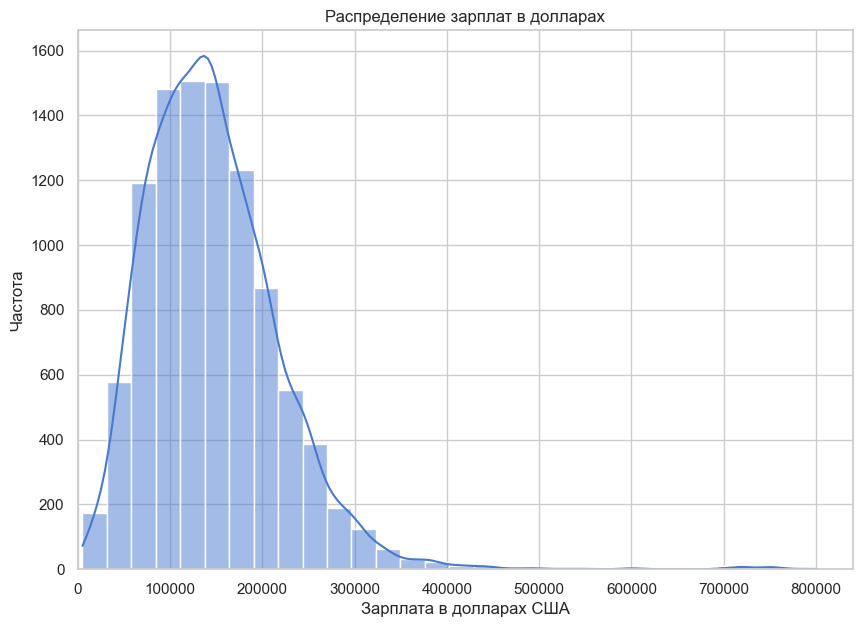

In [11]:
skewness = df['salary_in_usd'].skew()
print(f"Смещение ЗП от среднего: {skewness:.2f}")

plt.figure(figsize=(10, 7))
sns.histplot(df, x="salary_in_usd", kde=True, bins=30)
plt.title("Распределение зарплат в долларах")
plt.xlabel("Зарплата в долларах США")
plt.ylabel("Частота")
plt.xlim(0)
plt.savefig("plots/Распределение_зарплат_в_долларах.png", dpi=300, bbox_inches='tight')
plt.show()

## b) Зарплата по уровню опыта (Boxplot)

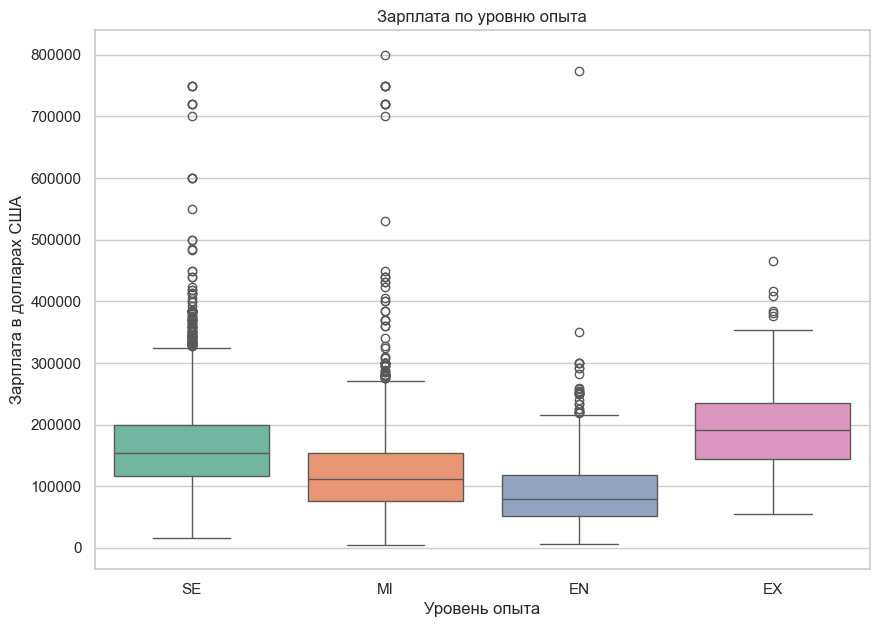

In [12]:
plt.figure(figsize=(10, 7))
sns.boxplot(df, x="experience_level", y="salary_in_usd", palette="Set2")
plt.title("Зарплата по уровню опыта")
plt.xlabel("Уровень опыта")
plt.ylabel("Зарплата в долларах США")
plt.savefig("plots/Зарплата_по_уровню_опыта.png", dpi=300, bbox_inches='tight')
plt.show()

**Уровень опыта сотрудников:**  

- **SE (Senior)** – **Старший специалист**: Опытный профессионал с глубокими знаниями в своей области, способный брать на себя сложные задачи и руководить проектами.  
- **MI (Mid-Level)** – **Средний уровень**: Специалист с достаточным опытом, способный работать автономно, но всё же не на уровне эксперта.  
- **EN (Entry-Level)** – **Начальный уровень (Junior)**: Специалист на старте карьеры, обычно с ограниченным опытом, но готовый обучаться.  
- **EX (Executive/Director)** – **Руководитель/Директор**: Человек на руководящей должности, отвечающий за стратегические решения и управление командой.  

## c) Частота названий должностей (Countplot)

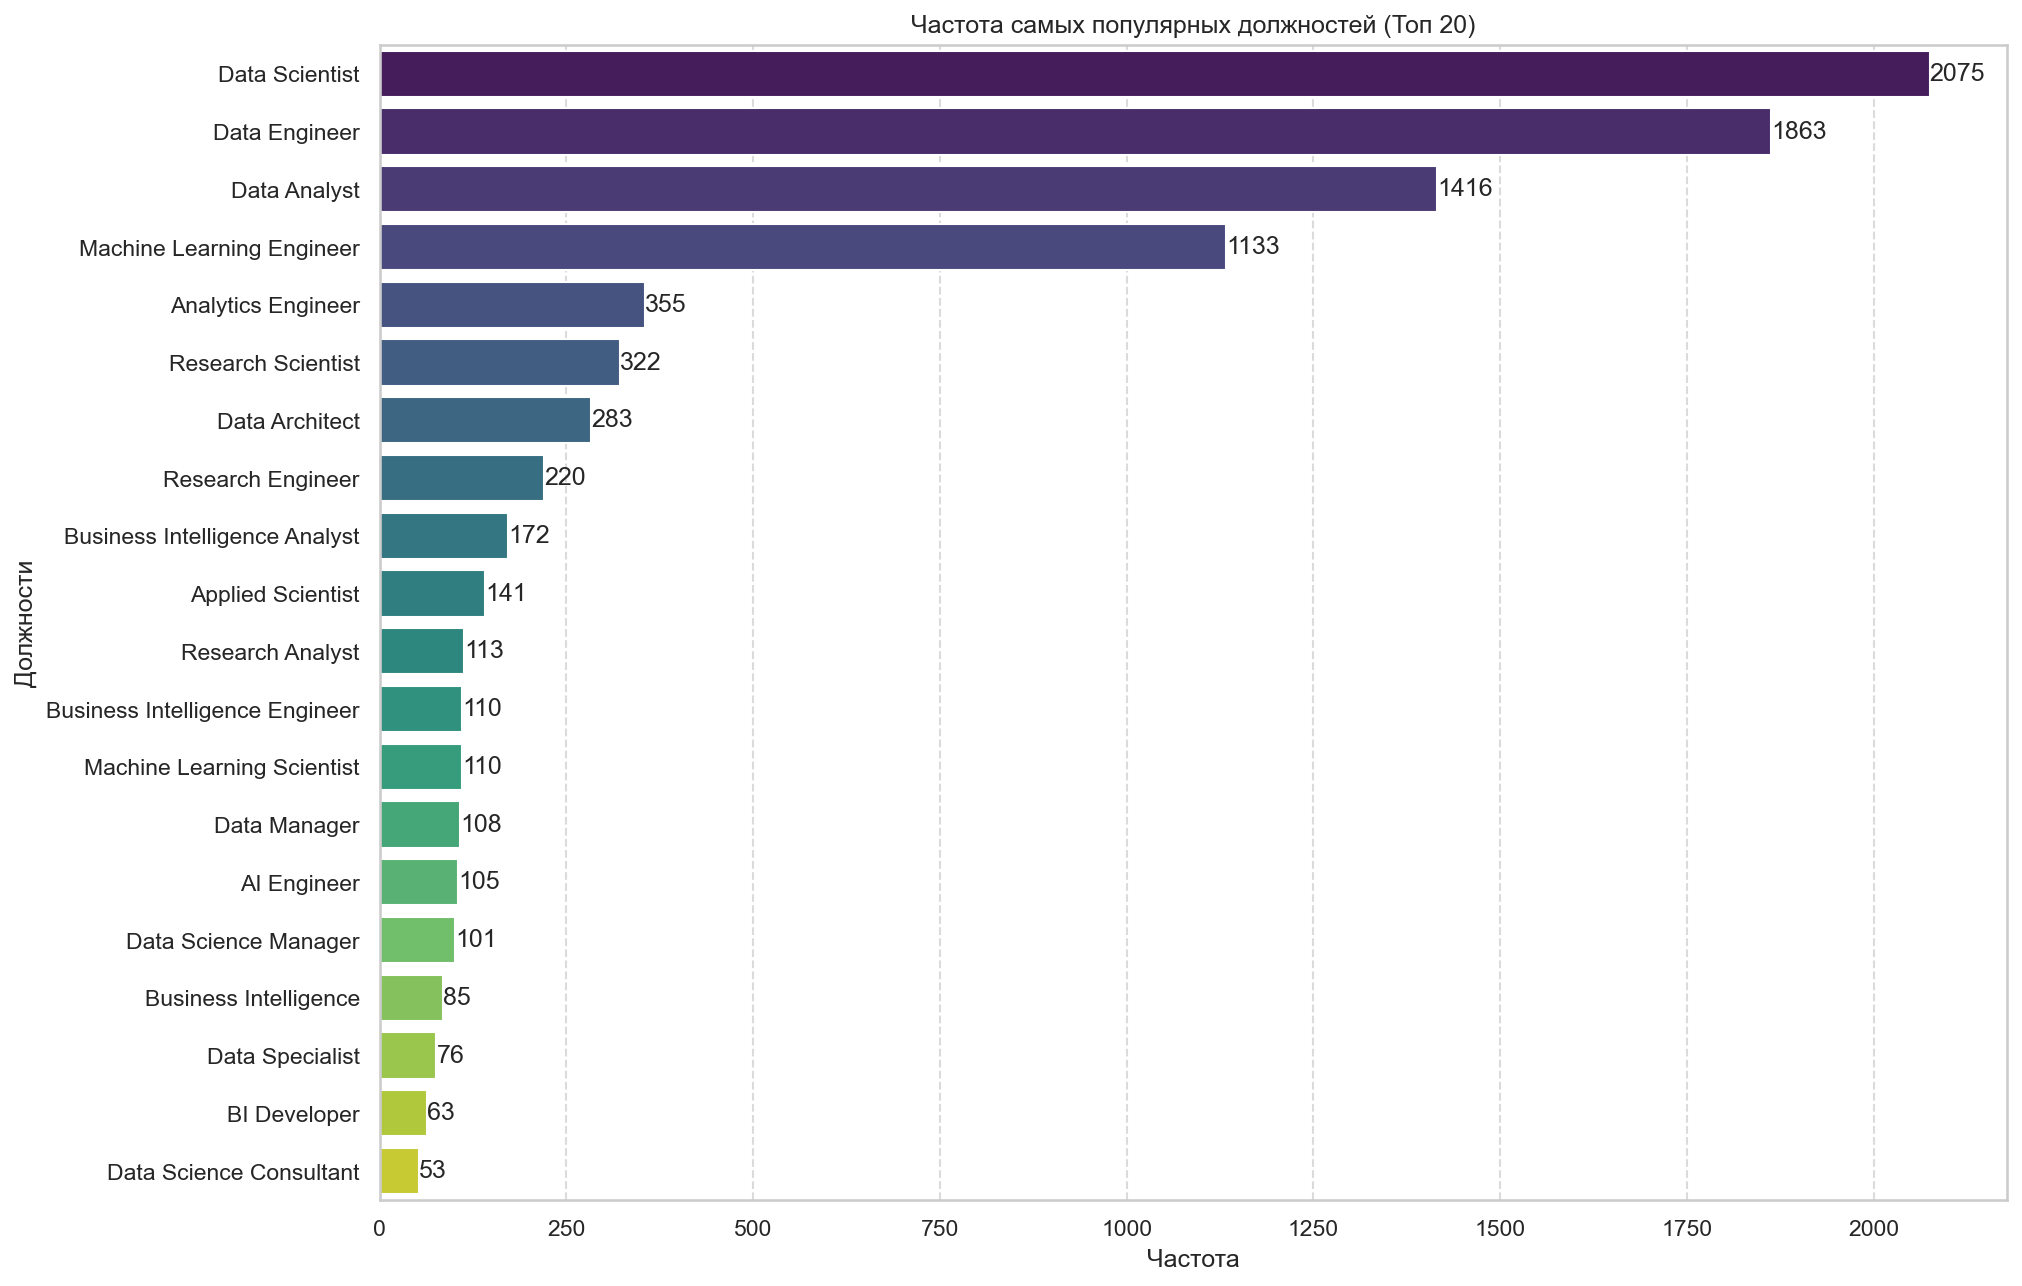

In [13]:
plt.figure(figsize=(14, 10), dpi=150)

top_job_titles = df["job_title"].value_counts().nlargest(20)

sns.barplot(y=top_job_titles.index, x=top_job_titles.values, palette="viridis")
plt.title("Частота самых популярных должностей (Топ 20)")
plt.xlabel("Частота")
plt.ylabel("Должности")

for index, value in enumerate(top_job_titles):
    plt.text(value, index, str(value), va="center")
    
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.savefig("plots/Частота_самых_популярных_должностей.png", dpi=300, bbox_inches='tight')
plt.show()

## d) Частота должностей по странам

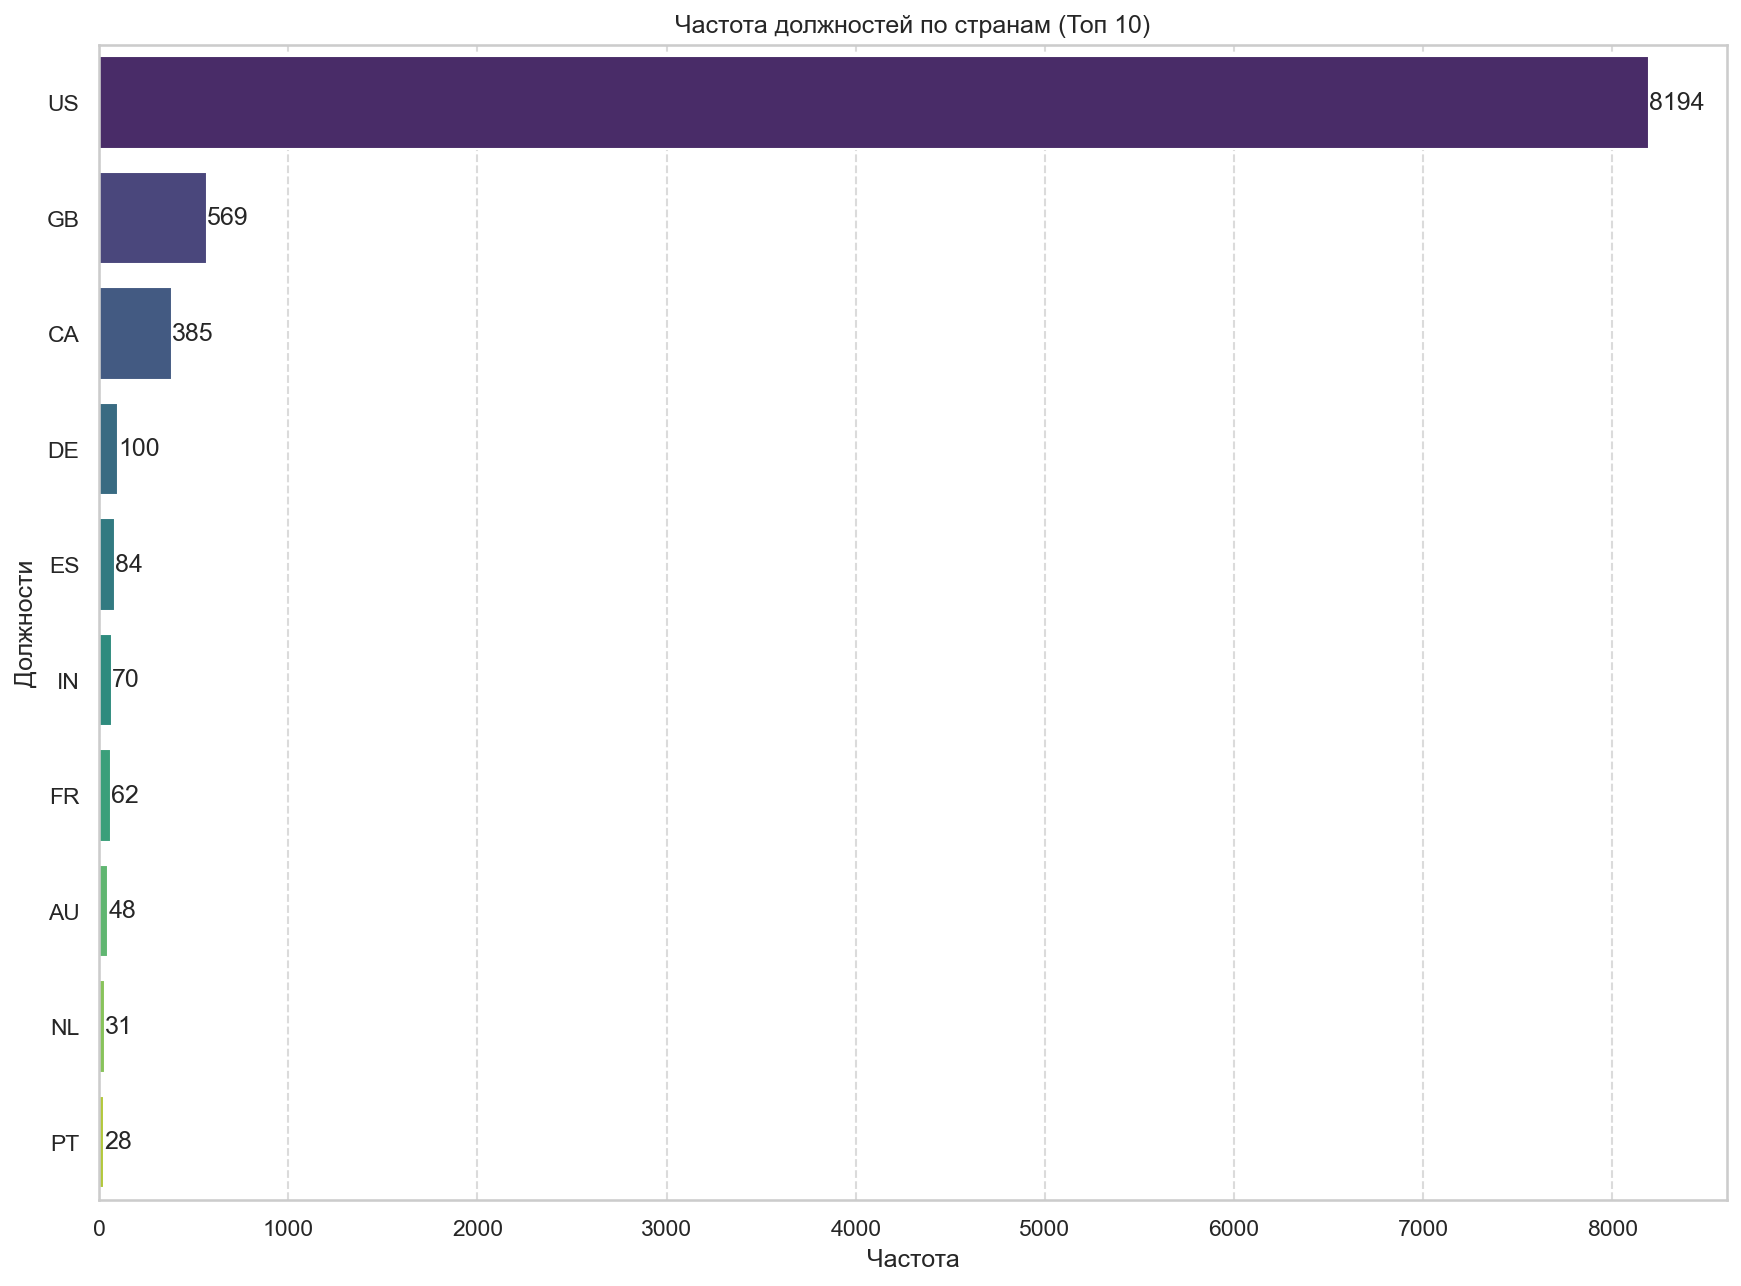

In [14]:
plt.figure(figsize=(14, 10), dpi=150)

top_job_titles = df["company_location"].value_counts().nlargest(10)

sns.barplot(y=top_job_titles.index, x=top_job_titles.values, palette="viridis")
plt.title("Частота должностей по странам (Топ 10)")
plt.xlabel("Частота")
plt.ylabel("Должности")

for index, value in enumerate(top_job_titles):
    plt.text(value, index, str(value), va="center")
    
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.savefig("plots/Частота_должностей_по_странам.png", dpi=300, bbox_inches='tight')
plt.show()

## e) Коэффициент удаленной работы vs зарплата (Scatterplot)

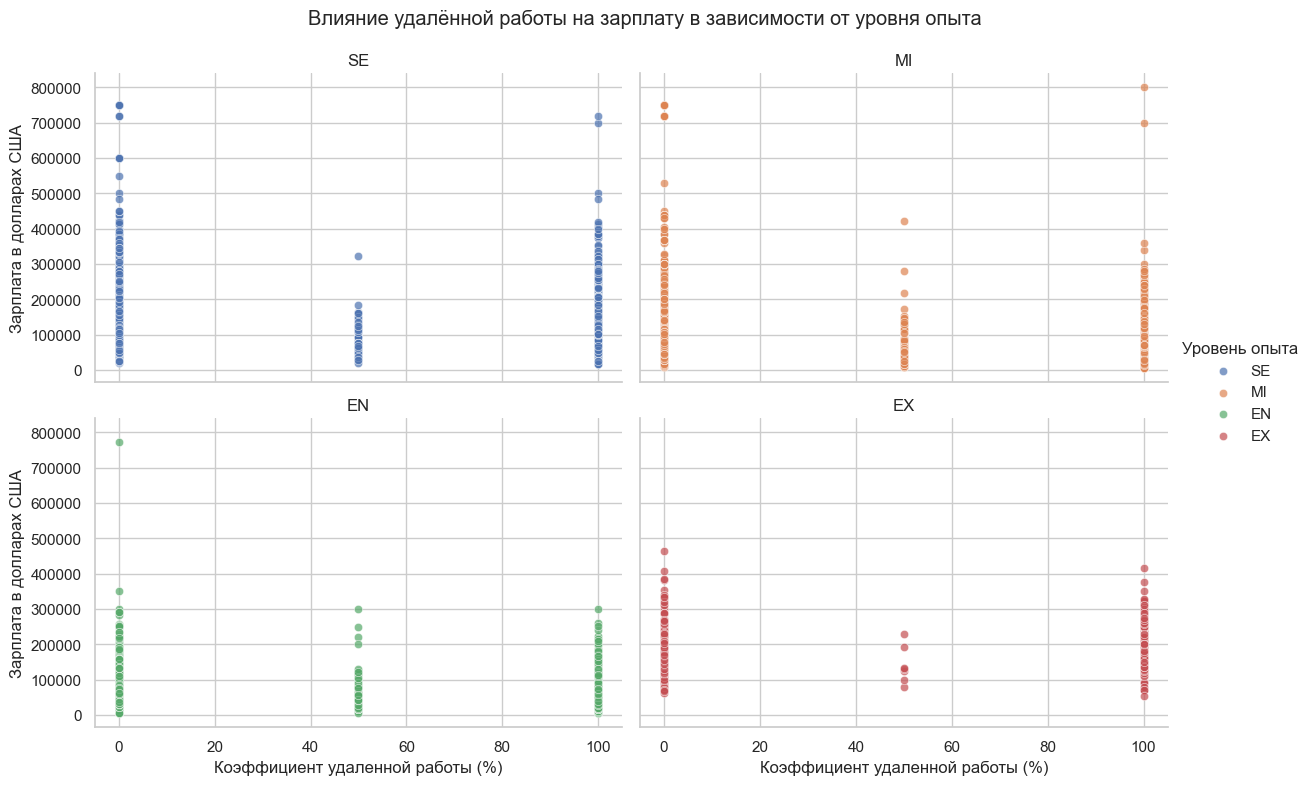

In [15]:
g = sns.FacetGrid(df, col="experience_level", col_order=['SE', 'MI', 'EN', 'EX'], col_wrap=2, height=4, aspect=1.5, hue="experience_level", palette="deep")

g.map_dataframe(sns.scatterplot, x="remote_ratio", y="salary_in_usd", alpha=0.7)
g.set_axis_labels("Коэффициент удаленной работы (%)", "Зарплата в долларах США")
g.set_titles(col_template="{col_name}")
g.add_legend(title="Уровень опыта")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Влияние удалённой работы на зарплату в зависимости от уровня опыта")

plt.savefig("plots/Влияние_удалённой_работы_на_зарплату.png", dpi=300, bbox_inches='tight')
plt.show()

## f) Средняя зарплата по должностям (Bar Plot)

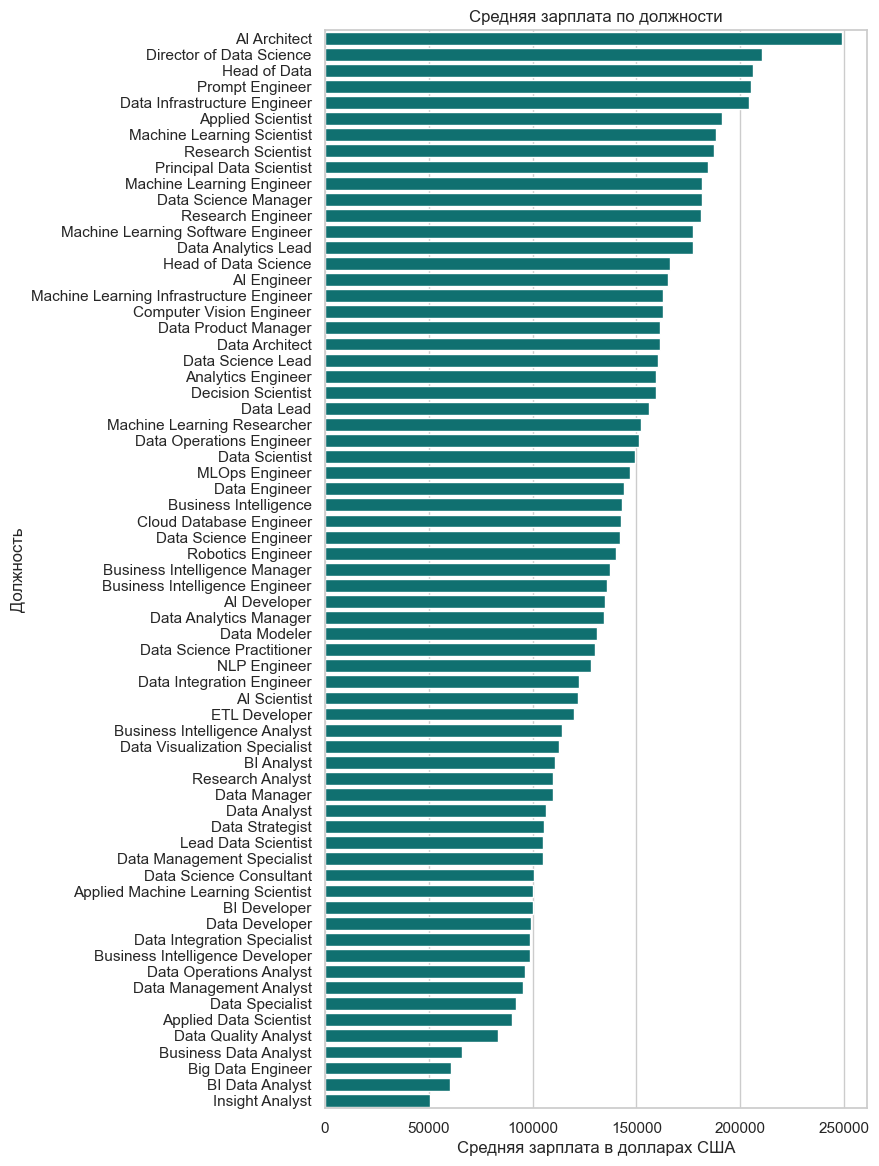

In [16]:
plt.figure(figsize=(7, 14))
job_salary = df.groupby('job_title')["salary_in_usd"].mean().sort_values(ascending=False).round()

sns.barplot(y=job_salary.index, x=job_salary.values, color="teal")
plt.title("Средняя зарплата по должности")
plt.xlabel("Средняя зарплата в долларах США")
plt.ylabel("Должность")
plt.savefig("plots/Средняя_зарплата_по_должностям.png", dpi=300, bbox_inches='tight')
plt.show()


## g) Изменение заработной платы по годам (Bar Plot)

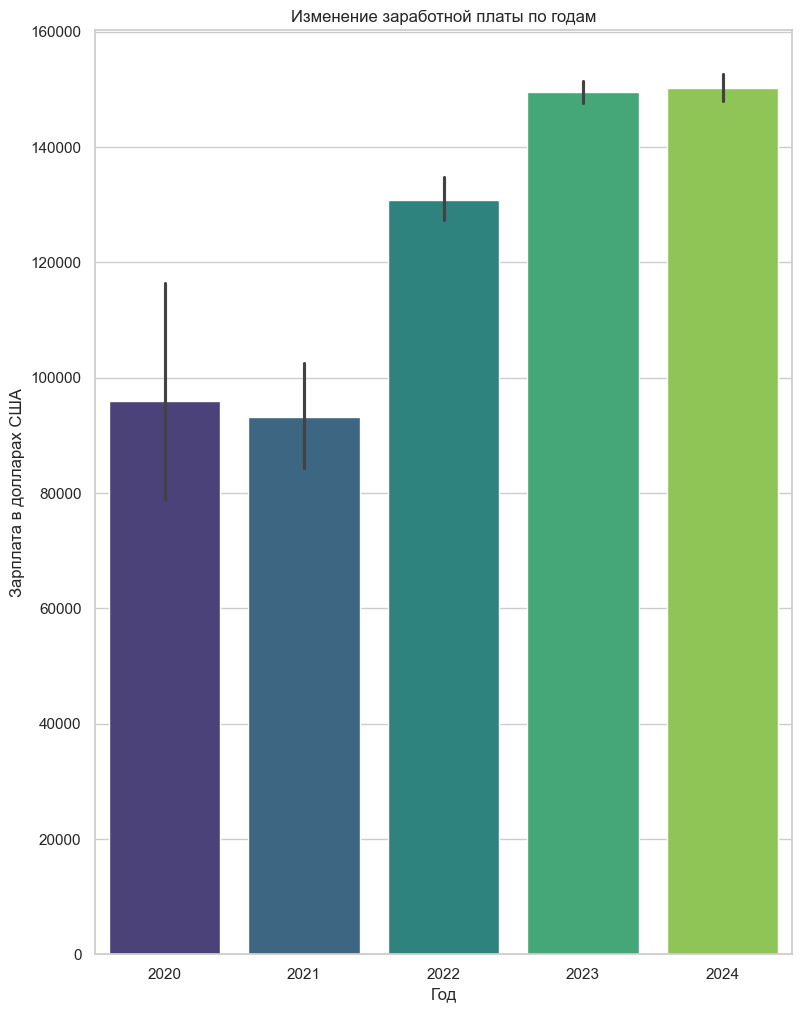

In [17]:
plt.figure(figsize=(9, 12))
sns.barplot(df, x="work_year", y="salary_in_usd", palette="viridis")
plt.title("Изменение заработной платы по годам")
plt.xlabel("Год")
plt.ylabel("Зарплата в долларах США")
plt.savefig("plots/Изменение_заработной_платы_по_годам.png", dpi=300, bbox_inches='tight')
plt.show()

## h) Распределение уровней опыта

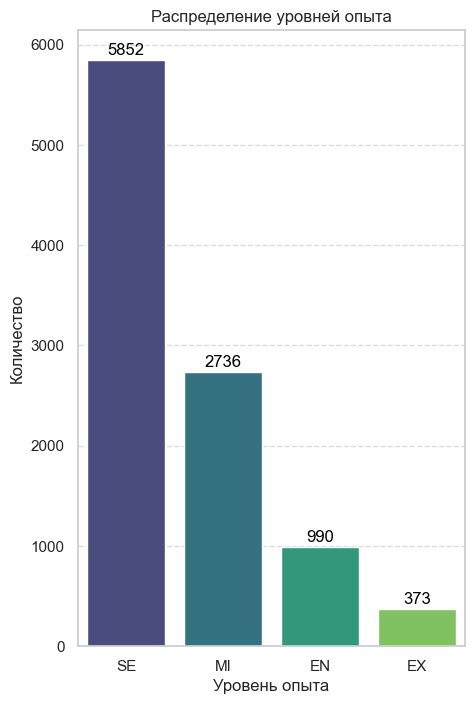

In [18]:
experience_counts = df["experience_level"].value_counts().reset_index()
experience_counts.columns = ["experience_level", "count"]

plt.figure(figsize=(5, 8))
ax = sns.barplot(data=experience_counts, x="experience_level", y="count", palette="viridis")

for index, row in experience_counts.iterrows():
    ax.text(row["experience_level"], row["count"] + 50, str(row["count"]), color='black', ha="center", fontsize=12)

plt.xlabel("Уровень опыта")
plt.ylabel("Количество")
plt.title("Распределение уровней опыта")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("plots/Распределение_уровней_опыта.png", dpi=300, bbox_inches='tight')
plt.show()


## i) Изменение заработной платы по годам в зависимости от уровня опыта

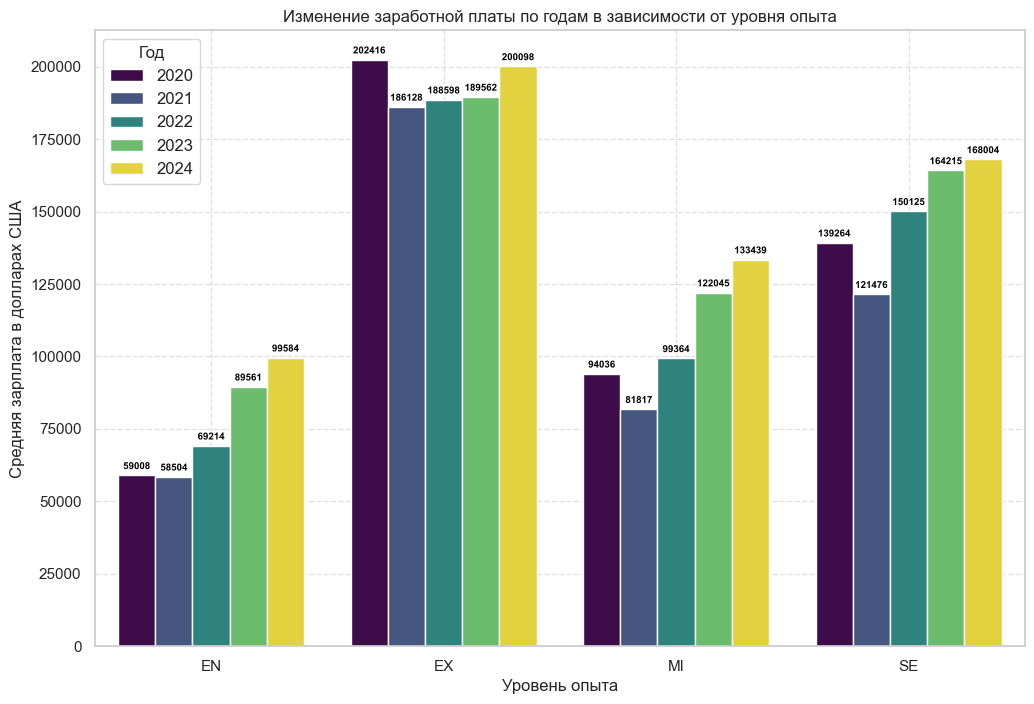

In [19]:
exp_salary = df.groupby(['experience_level', 'work_year'])['salary_in_usd'].mean().round().reset_index()

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=exp_salary, hue="work_year", y="salary_in_usd", x="experience_level", palette="viridis", dodge=True)

for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", label_type="edge", fontsize=7, fontweight='bold', color='black',
                 padding=3, path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

plt.title("Изменение заработной платы по годам в зависимости от уровня опыта")
plt.xlabel("Уровень опыта")
plt.ylabel("Средняя зарплата в долларах США")
plt.legend(title="Год", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

plt.savefig("plots/Изменение_заработной_платы.png", dpi=300, bbox_inches='tight')
plt.show()


## j) Тепловая карта корреляции для числовых признаков

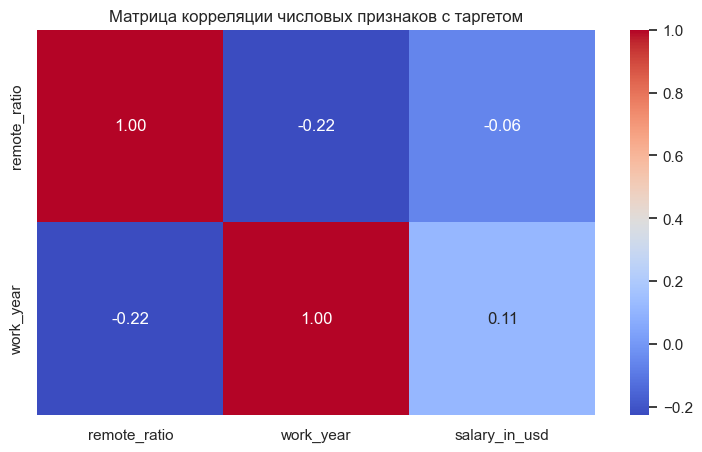

In [20]:
numeric_cols = df.select_dtypes("number").drop(columns="salary").columns.sort_values().tolist()

if "salary_in_usd" in numeric_cols:
    numeric_cols.remove("salary_in_usd")
    numeric_cols.append("salary_in_usd")

cor_matrix = df[numeric_cols].corr()
cor_matrix = cor_matrix[numeric_cols].loc[numeric_cols][:-1]

plt.figure(figsize=(9, 5), dpi=100)
sns.heatmap(cor_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляции числовых признаков с таргетом")
plt.savefig("plots/Матрица_корреляции_числовых_признаков.png", dpi=300, bbox_inches='tight')
plt.show()


# 5. Предобработка

In [38]:
features = df.drop(columns=["salary", "salary_in_usd"]).columns.tolist()
target = "salary_in_usd"

X = df[features].copy()
y = df[target].copy()

cat_cols = X.select_dtypes("object").columns.tolist()
num_cols = X.select_dtypes("number").columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)

In [56]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', TargetEncoder(), cat_cols)
    ]
)

preprocessor_pr = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('poly', PolynomialFeatures(degree=3, include_bias=False)),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', TargetEncoder(), cat_cols)
    ]
)


cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
scoring_opt = "neg_mean_absolute_percentage_error"


# 6. Моделирование
## Модель 1: Линейная регрессия

In [57]:
# Модель Linear Regression
# model_lr = LinearRegression()
model_lr = Ridge()

# Определение параметров для LinReg
param_grid_lr = {
    'model__fit_intercept': [True, False],
    'model__alpha': np.logspace(-3, 3, 100),
    'model__max_iter': [100, 200, 300, 400, 500],
    'model__solver': ['auto', 'svd', 'cholesky', 'saga', 'lbfgs']
}


# Пайплайн для Linear Regression
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_lr)
])

# RandomizedSearchCV для Linear Regression
search_lr = RandomizedSearchCV(
    pipeline_lr,
    param_distributions=param_grid_lr,
    n_iter=200,
    cv=cv_folds,
    scoring=scoring_opt,
    n_jobs=-1
)

search_lr.fit(X_train, y_train)

# Получение лучших параметров
best_pipeline_lr = search_lr.best_estimator_
best_params_lr = search_lr.best_params_
print("Лучшие параметры для Linear Regression:", best_params_lr)

# Оценка на тестовом наборе
y_pred_lr = best_pipeline_lr.predict(X_test)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
print("MAPE на тестовых данных:", mape_lr)

Лучшие параметры для Linear Regression: {'model__solver': 'auto', 'model__max_iter': 300, 'model__fit_intercept': True, 'model__alpha': 432.87612810830615}
MAPE на тестовых данных: 0.3868123362361678


## Модель 2: Полиномиальная регрессия

In [58]:
# Определение модели
model_pr = Ridge()

# Определение параметров для PolyReg
param_grid_pr = {
    'model__fit_intercept': [True, False],
    'model__alpha': np.logspace(-3, 3, 100),
    'model__max_iter': [100, 200, 300, 400, 500],
    'model__solver': ['auto', 'svd', 'cholesky', 'saga', 'lbfgs']
}

# Создание пайплайна
pipeline_pr = Pipeline(steps=[
    ('preprocessor', preprocessor_pr),
    ('model', model_pr)
])

# RandomizedSearchCV для polyreg
search_pr = RandomizedSearchCV(
    pipeline_pr,
    param_distributions=param_grid_pr,
    n_iter=200,
    cv=cv_folds,
    scoring=scoring_opt,
    n_jobs=-1
)

# Обучение модели
search_pr.fit(X_train, y_train)

# Получение лучших параметров
best_pipeline_pr = search_pr.best_estimator_
best_params_pr = search_pr.best_params_
print("Лучшие параметры для Polynomial Regression:", best_params_pr)

# Оценка на тестовом наборе
y_pred_pr = best_pipeline_pr.predict(X_test)
mape_pr = mean_absolute_percentage_error(y_test, y_pred_pr)
print("MAPE на тестовых данных:", mape_pr)


Лучшие параметры для Polynomial Regression: {'model__solver': 'svd', 'model__max_iter': 300, 'model__fit_intercept': True, 'model__alpha': 0.0011497569953977356}
MAPE на тестовых данных: 0.3864017978269637


## Модель 3: Random Forest

In [66]:
# Модель Random Forest
model_rf = RandomForestRegressor()

# Параметры для RandomizedSearchCV
param_grid_rf = {
    'model__n_estimators': [
        60,
        75,
        90,
        120,
        150,
        180
    ],
    'model__max_depth': [
        7,
        8,
        9,
        10,
        12,
    ],
    'model__min_samples_split': [
        4,
        5,
        6, 
        7,
        8,
        10
    ],
    'model__min_samples_leaf': [
        3,
        4,
        5
    ],
    'model__max_features': [ 
        'log2'
    ]
}

# Пайплайн для Random Forest
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_rf)
])

# RandomizedSearchCV для Random Forest
search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_grid_rf,
    n_iter=100,
    cv=cv_folds,
    scoring=scoring_opt,
    n_jobs=-1
)

# Обучение модели
search_rf.fit(X_train, y_train)

# Получение лучших параметров
best_pipeline_rf = search_rf.best_estimator_
best_params_rf = search_rf.best_params_
print("Лучшие параметры для Random Forest:", best_params_rf)

# Оценка на тестовом наборе
y_pred_rf = best_pipeline_rf.predict(X_test)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
print("MAPE на тестовых данных:", mape_rf)

Лучшие параметры для Random Forest: {'model__n_estimators': 60, 'model__min_samples_split': 5, 'model__min_samples_leaf': 3, 'model__max_features': 'log2', 'model__max_depth': 10}
MAPE на тестовых данных: 0.3543534540008636


## Модель 4: CatBoost

In [67]:
# Модель CatBoost
model_cb = CatBoostRegressor(verbose=0, loss_function='RMSE')  

{
    'model__random_strength': 1, 
    'model__learning_rate': 0.2, 
    'model__l2_leaf_reg': 4, 
    'model__iterations': 300, 
    'model__depth': 10, 
    'model__border_count': 256
}

# Параметры для RandomizedSearchCV
param_grid_cb = {
    'model__iterations': [
        200, 
        250,
        300,
        350,
        400,
     ],
    'model__learning_rate': [
        0.01,
        0.025,
        0.05,
        0.95,
        0.1,
        0.105,
        0.2,
    ],
    'model__depth': [
        3,
        4,
        5,
        6, 
        8, 
        10,
    ],
    'model__l2_leaf_reg': [
        1,
        2, 
        3,
        4,
        5,
        6,
    ],
    'model__random_strength': [
        1,
        2, 
        3,
        4
    ],
    'model__border_count': [
        128,
        256,
    ],
}

# Пайплайн для CatBoost
pipeline_cb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_cb)
])

# RandomizedSearchCV для CatBoost
search_cb = RandomizedSearchCV(
    pipeline_cb,
    param_distributions=param_grid_cb,
    n_iter=100,
    cv=cv_folds,
    scoring=scoring_opt,
    n_jobs=-1
)

# Обучение модели
search_cb.fit(X_train, y_train)

# Получение лучших параметров
best_pipeline_cb = search_cb.best_estimator_
best_params_cb = search_cb.best_params_
print("Лучшие параметры для CatBoost:", best_params_cb)

# Оценка на тестовом наборе
y_pred_cb = best_pipeline_cb.predict(X_test)
mape_cb = mean_absolute_percentage_error(y_test, y_pred_cb)
print("MAPE на тестовых данных:", mape_cb)

Лучшие параметры для CatBoost: {'model__random_strength': 1, 'model__learning_rate': 0.2, 'model__l2_leaf_reg': 5, 'model__iterations': 250, 'model__depth': 5, 'model__border_count': 256}
MAPE на тестовых данных: 0.3503867774429037


## Модель 5-6: MeanPredictor и MedianPredictor

In [68]:
# Модель, предсказывающая среднее
class MeanPredictor(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        """Запоминаем среднее значение"""
        self.mean_ = np.mean(y)
        return self

    def predict(self, X):
        """Всегда предсказываем среднее"""
        return np.full(shape=(X.shape[0],), fill_value=self.mean_)

# Модель, предсказывающая медиану
class MedianPredictor(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        """Запоминаем медиану"""
        self.median_ = np.median(y)
        return self

    def predict(self, X):
        """Всегда предсказываем медиану"""
        return np.full(shape=(X.shape[0],), fill_value=self.median_)

In [69]:
# Пайплайн для моделей
pipeline_mean = Pipeline(steps=[
    ('model', MeanPredictor())
])

pipeline_median = Pipeline(steps=[
    ('model', MedianPredictor())
])


# 7. Оценка качество моделей

In [70]:
# Модели
models = {
    "Mean Predictor": pipeline_mean,
    "Median Predictor": pipeline_median,
    "Linear Regression": best_pipeline_lr,
    "Polynomial  Regression": best_pipeline_pr,
    "Random Forest": best_pipeline_rf,
    "CatBoost": best_pipeline_cb,
}

# Сетки гиперпараметров
param_grids = {
    "Mean Predictor": {},
    "Median Predictor": {},
    "Linear Regression": param_grid_lr,
    "Polynomial  Regression": param_grid_pr,
    "Random Forest": param_grid_rf,
    "CatBoost": param_grid_cb,
}

# Лучшие гиперпараметры
best_params = {
    "Mean Predictor": {},
    "Median Predictor": {},
    "Linear Regression": best_params_lr,
    "Polynomial  Regression": best_params_pr,
    "Random Forest": best_params_rf,
    "CatBoost": best_params_cb,
}

## Определение лучшей модели по тестовой выборке

In [71]:
# Словарь для хранения предсказаний и результатов кросс-валидации
predictions = {
    "Model": [],
    "y_pred_train": [],
    "y_pred_test": [],
    "CV R2 Scores": []
}

# Сбор предсказаний и кросс-валидация
for name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='r2')
    
    predictions["Model"].append(name)
    predictions["y_pred_train"].append(y_pred_train)
    predictions["y_pred_test"].append(y_pred_test)
    predictions["CV R2 Scores"].append(cv_scores)

# Преобразование в DataFrame
predictions_df = pd.DataFrame(predictions)
print("\nПредсказания собраны:")


Предсказания собраны:


In [72]:
# Словарь для хранения метрик
results = {
    "Model": [],
    "MAPE Train (%)": [],
    "MAPE Test (%)": [],
    "R2 Train (%)": [],
    "R2 Test (%)": [],
    "CV R2 Mean (%)": []
}

# Расчет метрик
for index, row in predictions_df.iterrows():
    model_name = row["Model"]
    y_pred_train = row["y_pred_train"]
    y_pred_test = row["y_pred_test"]
    cv_scores = row["CV R2 Scores"]
    
    # Метрики на тренировочной выборке
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    # Метрики на тестовой выборке
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    # Среднее значение R2 по кросс-валидации
    cv_r2_mean = cv_scores.mean()
    
    # Добавление результатов
    results["Model"].append(model_name)
    results["MAPE Train (%)"].append(100 * mape_train)
    results["MAPE Test (%)"].append(100 * mape_test)
    results["R2 Train (%)"].append(100 * r2_train)
    results["R2 Test (%)"].append(100 * r2_test)
    results["CV R2 Mean (%)"].append(100 * cv_r2_mean)

# Преобразование в DataFrame
results_df = pd.DataFrame(results)

In [73]:
# Вывод результатов
print("Сравнение моделей по различным метрикам:")
display(results_df.round(2))

# Лучшая модель по MAPE
best_model_mape = results_df.loc[results_df["MAPE Test (%)"].idxmin()]
print(f"\nЛучшая модель по MAPE на тестовой выборке: {best_model_mape['Model']} "
      f"с MAPE = {best_model_mape['MAPE Test (%)']:.2f}%")

# Лучшая модель по R2
best_model_r2 = results_df.loc[results_df["R2 Test (%)"].idxmax()]
print(f"Лучшая модель по R2 на тестовой выборке: {best_model_r2['Model']} "
      f"с R2 = {best_model_r2['R2 Test (%)']:.2f}%")

Сравнение моделей по различным метрикам:


,Model,MAPE Train (%),MAPE Test (%),R2 Train (%),R2 Test (%),CV R2 Mean (%)
0,Mean Predictor,58.95,61.78,0.00,-0.06,-0.05
1,Median Predictor,55.53,58.32,-1.15,-1.67,-1.22
2,Linear Regression,37.72,38.68,31.60,33.88,30.43
3,Polynomial Regression,37.71,38.64,31.62,33.89,30.42
4,Random Forest,32.93,35.37,37.77,36.56,32.53
5,CatBoost,31.56,35.04,39.80,36.30,33.32



Лучшая модель по MAPE на тестовой выборке: CatBoost с MAPE = 35.04%
Лучшая модель по R2 на тестовой выборке: Random Forest с R2 = 36.56%


In [49]:
# Вывод результатов
print("Сравнение моделей по различным метрикам:")
display(results_df.round(2))

# Лучшая модель по MAPE
best_model_mape = results_df.loc[results_df["MAPE Test (%)"].idxmin()]
print(f"\nЛучшая модель по MAPE на тестовой выборке: {best_model_mape['Model']} "
      f"с MAPE = {best_model_mape['MAPE Test (%)']:.2f}%")

# Лучшая модель по R2
best_model_r2 = results_df.loc[results_df["R2 Test (%)"].idxmax()]
print(f"Лучшая модель по R2 на тестовой выборке: {best_model_r2['Model']} "
      f"с R2 = {best_model_r2['R2 Test (%)']:.2f}%")

Сравнение моделей по различным метрикам:


,Model,MAPE Train (%),MAPE Test (%),R2 Train (%),R2 Test (%),CV R2 Mean (%)
0,Mean Predictor,58.95,61.78,0.00,-0.06,-0.05
1,Median Predictor,55.53,58.32,-1.15,-1.67,-1.22
2,Linear Regression,37.72,38.68,31.60,33.88,30.43
3,Polynomial Regression,37.71,38.64,31.62,33.89,30.42
4,Random Forest,32.58,35.42,38.49,36.49,32.38
5,CatBoost,31.77,35.01,39.53,36.35,33.26



Лучшая модель по MAPE на тестовой выборке: CatBoost с MAPE = 35.01%
Лучшая модель по R2 на тестовой выборке: Random Forest с R2 = 36.49%


In [74]:
def save_dataframe_as_png(df, filename="plots/result_table.png", figsize=(9, 1.5)):
    
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('tight')
    ax.axis('off')

    row_colors = [['#f0f0f0' if i % 2 == 0 else '#ffffff' for _ in range(len(df.columns))] for i in range(len(df))]

    table = ax.table(
        cellText=df.values, 
        colLabels=df.columns, 
        cellLoc='center', 
        loc='center', 
        cellColours=row_colors
    )

    # Изменение стиля заголовков
    for j in range(len(df.columns)):
        cell = table[0, j]
        cell.set_facecolor('#40466e')
        cell.set_text_props(weight='bold', color='white')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df.columns))))

    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

# Сохранение таблицы с разными размерами
save_dataframe_as_png(df.reset_index().sample(17).sort_index(), "plots/df_table.png", figsize=(18, 3))
save_dataframe_as_png(results_df.round(2), "plots/result_table.png", figsize=(9, 1.5))


In [75]:
# Функция для визуализации важности признаков
def plot_feature_importance(model, X_train, model_name, save_in_png=False):
    if model_name in  ['Logistic Regression', 'Polynomial Regression']:
        importance = abs(model.coef_[0])
    else:
        importance = model.feature_importances_ 
    
    features = X_train.columns
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
    importance_df = importance_df.sort_values(by="Importance", ascending=False)
    
    # Визуализация важности признаков
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")
    plt.title(f"Feature Importance для {model_name}")
    plt.gca().invert_yaxis()  
    
    if save_in_png:
        plt.savefig(f"plots/{model_name.lower().replace(" ", "_")}_feature_importance.png", dpi=300, bbox_inches='tight')

    plt.show()



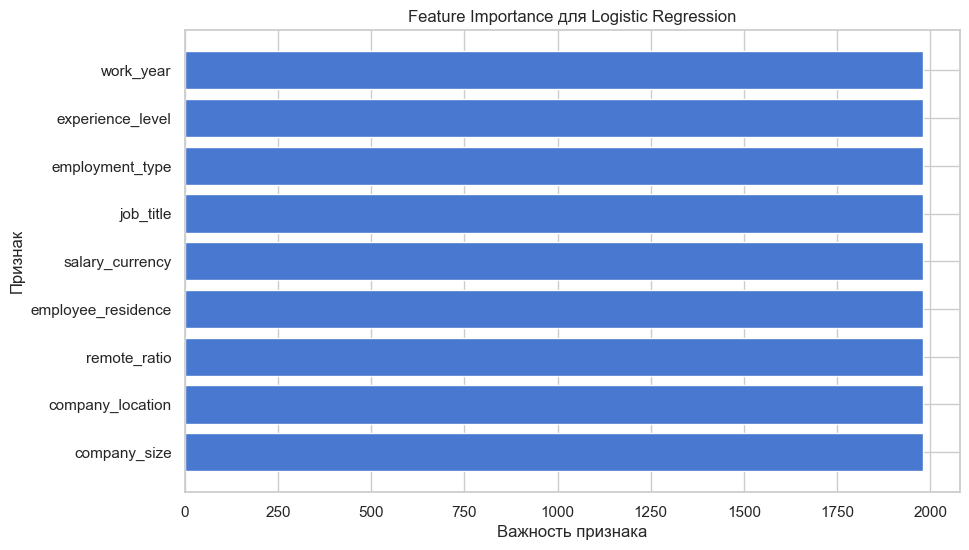

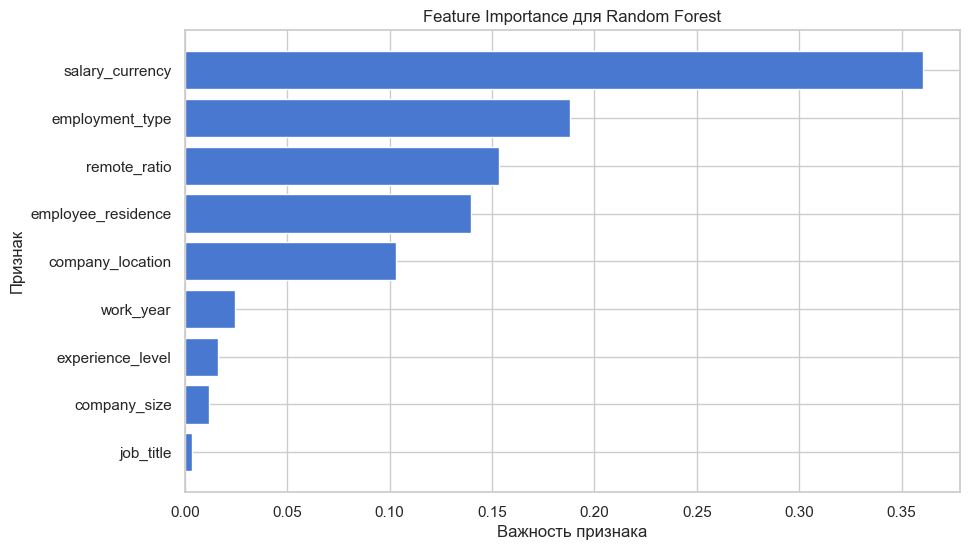

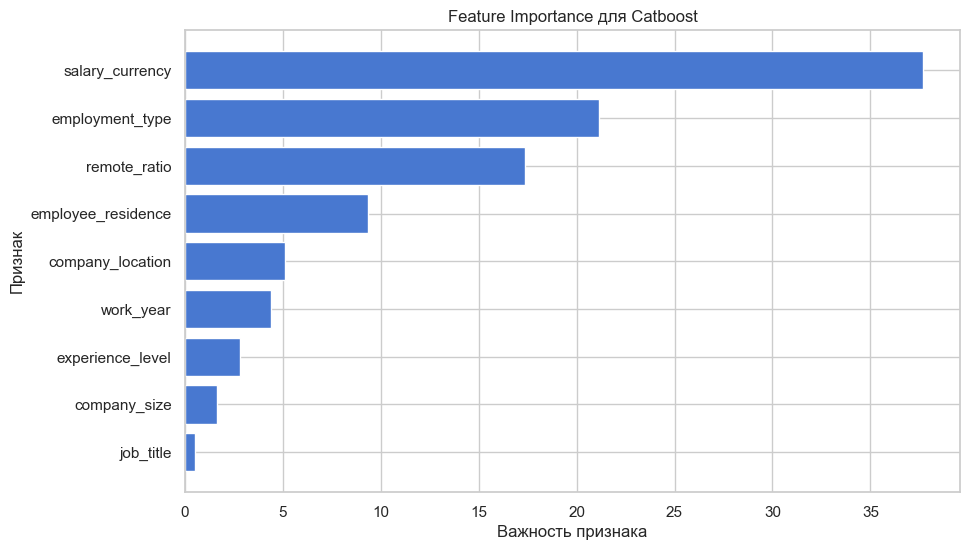

In [76]:
# Получение модели и визуализация важности признаков для логистической регрессии
model_lr = search_lr.best_estimator_.named_steps['model']
plot_feature_importance(model_lr, X_train, 'Logistic Regression')

# Получение модели и визуализация важности признаков для полиномиальной регрессии
# model_pr = search_pr.best_estimator_.named_steps['model']
# plot_feature_importance(model_pr, X_train, 'Polynomial Regression')

# Получение модели и визуализация важности признаков для RandomForest
model_rf = search_rf.best_estimator_.named_steps['model']
plot_feature_importance(model_rf, X_train, 'Random Forest', save_in_png=True)

# Получение модели и визуализация важности признаков для Catboost
model_cb = search_cb.best_estimator_.named_steps['model']
plot_feature_importance(model_cb, X_train, 'Catboost', save_in_png=True)

In [77]:
def tune_train_and_save_models(models_dict, best_params_dict, X, y, save_path="saved_models", models_to_tune=None):
    
    if models_to_tune is None:
        models_to_tune = ["Linear Regression", "Random Forest", "CatBoost"]

    os.makedirs(save_path, exist_ok=True)
    
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    # Применение лучших гиперпараметров
    for model_name in models_to_tune:
        if model_name in models_dict and model_name in best_params_dict and best_params_dict[model_name]:
            if model_name == "CatBoost":
                catboost_params = {key.replace("model__", ""): value for key, value in best_params_dict[model_name].items()}
                models_dict[model_name] = CatBoostRegressor(**catboost_params, cat_features=categorical_features, verbose=0)
            else:
                models_dict[model_name].set_params(**best_params_dict[model_name])

    # Обучение и сохранение моделей
    for model_name in models_to_tune:
        if model_name in models_dict:
            models_dict[model_name].fit(X, y)
            print(f"Модель '{model_name}' обучена с лучшими параметрами.")

            # Сохранение модели
            model_filename = os.path.join(save_path, f"{model_name.replace(' ', '_')}.pkl")
            joblib.dump(models_dict[model_name], model_filename)
            print(f"Модель '{model_name}' сохранена в {model_filename}")

    return models_dict


In [78]:
# Модели
models_final = {
    "Linear Regression": pipeline_lr,
    "Random Forest": pipeline_rf,
    "CatBoost": pipeline_cb,
}

# Использование функции
models_final = tune_train_and_save_models(models_final, best_params, X, y)

Модель 'Linear Regression' обучена с лучшими параметрами.
Модель 'Linear Regression' сохранена в saved_models\Linear_Regression.pkl
Модель 'Random Forest' обучена с лучшими параметрами.
Модель 'Random Forest' сохранена в saved_models\Random_Forest.pkl
Модель 'CatBoost' обучена с лучшими параметрами.
Модель 'CatBoost' сохранена в saved_models\CatBoost.pkl


In [85]:
def tune_train_and_save_models(models_dict, best_params_dict, X, y, save_path="saved_models", models_to_tune=None):
    
    if models_to_tune is None:
        models_to_tune = ["Linear Regression", "Random Forest", "CatBoost"]

    os.makedirs(save_path, exist_ok=True)
    
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    # Применение лучших гиперпараметров
    for model_name in models_to_tune:
        if model_name in models_dict and model_name in best_params_dict and best_params_dict[model_name]:
            
            if model_name == "CatBoost":
                catboost_params = {key.replace("model__", ""): value for key, value in best_params_dict[model_name].items()}
                models_dict[model_name] = CatBoostRegressor(**catboost_params, cat_features=categorical_features, verbose=0)
            
            elif model_name == "Random Forest":
                valid_rf_params = ["n_estimators", "min_samples_split", "min_samples_leaf", "max_features", "max_depth"]
                filtered_params_rf = {key.replace("model__", ""): value for key, value in best_params_dict[model_name].items() if key.replace("model__", "") in valid_rf_params}
                models_dict[model_name].named_steps["model"].set_params(**filtered_params_rf)
            
            elif model_name == "Linear Regression":
                valid_lr_params = ["fit_intercept"]
                filtered_params_lr = {key.replace("model__", ""): value for key, value in best_params_dict[model_name].items() if key.replace("model__", "") in valid_lr_params}
                models_dict[model_name].named_steps["model"].set_params(**filtered_params_lr)

    # Обучение и сохранение моделей
    for model_name in models_to_tune:
        if model_name in models_dict:
            models_dict[model_name].fit(X, y)
            print(f"Модель '{model_name}' обучена с лучшими параметрами.")

            # Сохранение модели
            model_filename = os.path.join(save_path, f"{model_name.replace(' ', '_')}.pkl")
            joblib.dump(models_dict[model_name], model_filename)
            print(f"Модель '{model_name}' сохранена в {model_filename}")

    return models_dict

# Использование исправленного кода
models_final = tune_train_and_save_models(models_final, best_params, X, y)


Модель 'Linear Regression' обучена с лучшими параметрами.
Модель 'Linear Regression' сохранена в saved_models\Linear_Regression.pkl
Модель 'Random Forest' обучена с лучшими параметрами.
Модель 'Random Forest' сохранена в saved_models\Random_Forest.pkl
Модель 'CatBoost' обучена с лучшими параметрами.
Модель 'CatBoost' сохранена в saved_models\CatBoost.pkl


In [79]:
def get_sum(s):
    return sum(list(map(int, s.split())))

In [80]:
get_sum("1 2 3")

6

In [82]:
best_params

{'Mean Predictor': {},
 'Median Predictor': {},
 'Linear Regression': {'model__solver': 'auto',
  'model__max_iter': 300,
  'model__fit_intercept': True,
  'model__alpha': 432.87612810830615},
 'Polynomial  Regression': {'model__solver': 'svd',
  'model__max_iter': 300,
  'model__fit_intercept': True,
  'model__alpha': 0.0011497569953977356},
 'Random Forest': {'model__n_estimators': 60,
  'model__min_samples_split': 5,
  'model__min_samples_leaf': 3,
  'model__max_features': 'log2',
  'model__max_depth': 10},
 'CatBoost': {'model__random_strength': 1,
  'model__learning_rate': 0.2,
  'model__l2_leaf_reg': 5,
  'model__iterations': 250,
  'model__depth': 5,
  'model__border_count': 256}}

In [95]:
value = "company_size"

res = f"""{value}_code = st.selectbox("Страна сотрудника (ввод кода)", 
                                                list({value}_dict.keys()), 
                                                index=list({value}_dict.values()).index("US"))
            {value} = {value}_dict[{value}_code]"""

print(res)

company_size_code = st.selectbox("Страна сотрудника (ввод кода)", 
                                                list(company_size_dict.keys()), 
                                                index=list(company_size_dict.values()).index("US"))
            company_size = company_size_dict[company_size_code]
